In [18]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
#OS
import os
import random

In [56]:
class Lung_Dataset(Dataset):
    """
    Lung Dataset Consisting of Infected and Non-Infected.
    """

    def __init__(self, purpose, verbose=0, transform = None):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        
        Parameter:
        -purpose variable should be set to a string of either 'train', 'test' or 'val'
        -verbose takes an int of either 0,1 or 2. 0 will only differentiate between normal and infected, 1 will differentiate
            between normal, covid and non-covid while 2 will only differentiate between covid and non-covid
        """
        self.purpose = purpose
        self.verbose = verbose
        self.transform = transform

        # All images are of size 150 x 150
        self.img_size = (150, 150)
            
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',
                              'train_infected': './dataset/train/infected/',
                              'train_infected_covid': './dataset/train/infected/covid',
                              'train_infected_non_covid': './dataset/train/infected/non-covid',
                              'test_normal': './dataset/test/normal/',
                              'test_infected': './dataset/test/infected/',
                              'test_infected_covid': './dataset/test/infected/covid',
                              'test_infected_non_covid': './dataset/test/infected/non-covid',
                              'val_normal': './dataset/val/normal/',
                              'val_infected': './dataset/val/infected/',
                              'val_infected_covid': './dataset/val/infected/covid',
                              'val_infected_non_covid': './dataset/val/infected/non-covid'}
        
        #Contains the number of images that will be used in our dataset. To be populated below
        self.dataset_numbers = {}
        
        # Consider normal and infected only
        if verbose == 0:
            self.classes = {0: 'normal', 1: 'infected'}
            
            #Populate self.dataset_numbers
            for condition in self.classes.values():
                #Key that will be used to access the dictionary
                key = "{}_{}".format(self.purpose, condition)
                if condition == "normal":
                    #Retrieve the filepath and populate dataset_numbers with the number of images in that folder
                    file_path = self.dataset_paths[key]
                    count = len(os.listdir(file_path))
                    self.dataset_numbers[key] = count
                    
                #For the infected case, we will be combining the covid and non-covid images into 1 category
                else:
                    #Need the keys for both covid and non-covid
                    key1 = key + "_covid"
                    key2 = key + "_non_covid"
                    file_path1 = self.dataset_paths[key1]
                    file_path2 = self.dataset_paths[key2]
                    count1 = len(os.listdir(file_path1))
                    count2 = len(os.listdir(file_path2))
                    #Number of infected images will be number of covid + number of non-covid
                    count = count1 + count2
                    self.dataset_numbers[key] = count
                       
        #Consider normal, covid and non-covid
        elif verbose == 1:
            self.classes = {0: 'normal', 1: 'covid', 2: 'non_covid'}
        
            #Populate self.dataset_numbers
            for condition in self.classes.values():
                #Similar to verbose == 0 above
                if condition == "normal":
                    key = "{}_{}".format(self.purpose, condition)
                    file_path = self.dataset_paths[key]
                    count = len(os.listdir(file_path))
                    self.dataset_numbers[key] = count
                    
                #For the infected case, we will be considering the covid and non-covid separately
                else:
                    #key = {purpose}_infected_covid or key = {purpose})_infected_non_covid
                    key = "{}_infected".format(self.purpose)
                    #Obtain the respective keys, retrieve the filepaths, populate dataset_numbers accordingly
                    key1 = key + "_covid"
                    key2 = key + "_non_covid"
                    file_path1 = self.dataset_paths[key1]
                    file_path2 = self.dataset_paths[key2]
                    count1 = len(os.listdir(file_path1))
                    count2 = len(os.listdir(file_path2))
                    self.dataset_numbers[key1] = count1
                    self.dataset_numbers[key2] = count2
                
        #Consider covid and non-covid
        elif verbose == 2:
            self.classes = {0: 'covid', 1 :'non_covid' }

            #Populate self.dataset_numbers
            for condition in self.classes.values():
                #Similar to the infected case in verbose 2
                key = "{}_infected".format(self.purpose)
                key1 = key + "_covid"
                key2 = key + "_non_covid"
                file_path1 = self.dataset_paths[key1]
                file_path2 = self.dataset_paths[key2]
                count1 = len(os.listdir(file_path1))
                count2 = len(os.listdir(file_path2))
                self.dataset_numbers[key1] = count1
                self.dataset_numbers[key2] = count2
            
        else:
            err_msg  = "Verbose argument only takes in an int of either 0,1 or 2"
            raise TypeError(err_msg)
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung {} Dataset in the 50.039 Deep Learning class project".format(self.purpose)
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_numbers.items():
            file_path = self.dataset_paths[key]
            msg += " - {}, in folder {}: {} images.\n".format(key, file_path, val)
        print(msg)
        
        
    def open_img(self, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        #Error handling 1
        group_val = self.purpose
        err_msg = "Error - For verbose = {}, class_val variable should be set to ".format(self.verbose)
        count = 0
        for value in self.classes.values():
            add_on = "'" + value + "'"
            if count < (len(self.classes.values()) -1):
                add_on += ' or '
            err_msg += add_on
            count += 1
        assert class_val in self.classes.values(), err_msg
        
        #For covid and non_covid, we want the class val to be "infected_covid" or "infected_non_covid"
        if class_val == 'covid' or class_val == 'non_covid':
            class_val = 'infected_' + class_val
            
        #Error Handling 2
        #Retrieve the max_val from self.dataset_numbers using the respective keys
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        class_val_err = class_val.replace('_', '/')
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val_err, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val < max_val, err_msg
        
        #Retrieve the image file path
        if class_val != "infected":
            #path_to_file will be the filepath/index_val 
            #Filepath is the path to the dataset folder as stored in self.dataset_paths
            #index_val is the image number that we want to retrieve
            path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        
        #If the class_val == infected, we need to take into account for both covid and non_covid images as they both
        #make up the infected class
        else:
            #Retrieve the number of images in the covid folder
            covid_count = len(os.listdir(self.dataset_paths['{}_{}_covid'.format(group_val, class_val)]))
            
            #If the infected image number we want to retrieve is smaller than the max image number in the covid folder,
            #We retrieve the infected image from the covid folder
            if index_val < covid_count:
                path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}_covid'.format(group_val, class_val)], index_val)
            
            #Else if it is greater, we move on to the non_covid folder and retrieve the image from there
            else:
                index_val = index_val - covid_count #remember that the image index starts from 0, so we got to reset the index
                path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}_non_covid'.format(group_val, class_val)], index_val)
        
        #Retrieve the image using the file path
        with open(path_to_file, 'rb') as f:
            im = Image.open(f)
            im.load()
        return im
    
    def show_img(self, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        # Open image
        im = self.open_img(class_val, index_val)
        
        # Display
        plt.imshow(im)
        return im
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        # Length function
        return sum(self.dataset_numbers.values())
    
    def length(self):
        return sum(self.dataset_numbers.values())
    
    def retrieve_image(self, index):
        im, label = self.__getitem__(index)
        return im, label
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """

        #If we only have 2 classes
        if self.verbose == 0 or self.verbose == 2:
            #Get the total number of images belonging to the first class
            first_val = int(list(self.dataset_numbers.values())[0])
            #As long as the index is smaller thatn the total, this image belongs to that class
            if index < first_val:
                class_val = self.classes[0]
                label = torch.Tensor([1, 0])
                
            #Else, we move on to the next class
            else:
                class_val = self.classes[1]
                index = index - first_val #Remember to reset the index
                label = torch.Tensor([0, 1])
          
        #If we have 3 classes to consider
        elif self.verbose == 1:
            #Similar to the 2 class problem, just that we have 3 classes to consider now
            first_val = int(list(self.dataset_numbers.values())[0]) #total number belonging to first class
            second_val = int(list(self.dataset_numbers.values())[1]) #total number belonging to second class
            
            #First class
            if index < first_val:
                class_val = self.classes[0]
                label = torch.Tensor([1, 0, 0])
            
            #Second class
            elif index >= first_val and index < first_val + second_val:
                index = index - first_val #Reset Index
                class_val = self.classes[1]
                label = torch.Tensor([0,1,0])
            
            #Third class
            else:
                index = index-(first_val + second_val) #Reset index
                class_val = self.classes[2]
                label = torch.Tensor([0,0,1])
    
        else:
            raise TypeError("Verbose value is not 0,1 or 2")
            
        im = self.open_img(class_val, index)
        
        if self.transform is not None:
            im = self.transform(im)
        else:
            im = transforms.ToTensor()(im)
            
        return im, label

In [98]:
%matplotlib inline
class Lung_Dataset_Analysis():
    def __init__(self, transform = None):
        self.NCN_train = Lung_Dataset('train', verbose =1, transform = transform)
        self.NCN_test = Lung_Dataset('test', verbose =1, transform = transform)
        self.NCN_val = Lung_Dataset('val', verbose =1, transform = transform)
        
        
        self.n_train = self.NCN_train.dataset_numbers['train_normal']
        self.n_test = self.NCN_test.dataset_numbers['test_normal']
        self.n_val = self.NCN_val.dataset_numbers ['val_normal']
        
        self.c_train = self.NCN_train.dataset_numbers['train_infected_covid']
        self.c_test = self.NCN_test.dataset_numbers['test_infected_covid']
        self.c_val = self.NCN_val.dataset_numbers ['val_infected_covid']
        
        self.nc_train = self.NCN_train.dataset_numbers['train_infected_non_covid']
        self.nc_test = self.NCN_test.dataset_numbers['test_infected_non_covid']
        self.nc_val = self.NCN_val.dataset_numbers['val_infected_non_covid']
        
        self.normal_numbers = [self.n_train, self.n_test, self.n_val]
        self.covid_numbers = [self.c_train, self.c_test, self.c_val]
        self.non_covid_numbers = [self.nc_train, self.nc_test, self.nc_val]
        
        self.train_numbers = [self.n_train, self.c_train, self.nc_train]
        self.test_numbers = [self.n_test, self.c_test, self.nc_test]
        self.val_numbers = [self.n_val, self.c_val, self.nc_val]
        
        
    def print_charts(self, labels, sizes, title, explode=None):
        fig, ax = plt.subplots(1,2)
        fig.suptitle(title)
        ax[0].pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%')
        ax[0].axis('equal')
        
        ax[1].bar(labels, sizes)
        fig.tight_layout(pad = 3)

        plt.show()
        for label, size in zip(labels, sizes):
            print("{}: {} images".format(label,size))
        
        
    def total_ttv_size(self):
        total_train_size = sum(self.train_numbers)
        total_val_size = sum(self.val_numbers)
        total_test_size = sum(self.test_numbers)
        
        labels = ['Train', 'Test', 'Val']
        sizes = [total_train_size, total_test_size, total_val_size]
        explode = [0,0,0]
        title = "Total Breakdown of the Train, Test and Val Dataset"
        
        self.print_charts(labels, sizes, title, explode)
        
    def total_class_size(self):
        c_size = sum(self.covid_numbers)
        nc_size = sum(self.non_covid_numbers)
        n_size = sum(self.normal_numbers)
        
        labels = ['Normal', 'Covid', 'Non-Covid']
        sizes = [n_size, c_size, nc_size]
        explode = [0,0,0]
        title = "Total Breakdown of Normal, Covid and Non-Covid Classes"
        
        self.print_charts(labels, sizes, title, explode)
        
    def simple_class_size(self):
        n_size = sum(self.normal_numbers)
        nc_size = sum(self.non_covid_numbers)
        c_size = sum(self.covid_numbers)
        i_size = nc_size + c_size
        
        labels = ['Normal', 'Infected']
        sizes = [n_size, i_size]
        title = "Total Breakdown of Normal and Infected Classes"
        
        self.print_charts(labels, sizes, title)
        
    def class_size(self, class_type):
        err_msg = "Class type should either be 'normal', 'covid' or 'non_covid'"
        assert class_type in self.NCN_train.classes.values(), err_msg
        labels = ['Train', 'Test', 'Val' ]
        if class_type == 'normal':
            sizes = [size for size in self.normal_numbers]
        elif class_type == 'covid':
            sizes = [size for size in self.covid_numbers]
        else:
            sizes = [size for size in self.non_covid_numbers]
            
        title = "Total Breakdown of Train, Test and Val in the {} class".format(class_type)
        
        self.print_charts(labels, sizes, title)
     
    def print_image_plot(self, img):
        array_plot = img.flatten()
        y_axis = np.arange(array_plot.shape[0])
        plt.title('Image Values')
        plt.hist(array_plot)
        plt.xlabel("Pixel Value")
        plt.ylabel("Number of Pixels")
        plt.show()
        
        print("Min Value: {}". format(array_plot.min()))
        print("Max Value: {}".format(array_plot.max()))
    

    
    def print_random_image(self, group = None):
        groups = [self.NCN_train, self.NCN_test, self.NCN_val]
        if group == 'train':
            dataset = groups[0]
        elif group == 'test':
            dataset = groups[1]
        elif group == 'val':
            dataset == groups[2]
        else:
            group_value = random.randint(0,2)
            dataset = groups[group_value]
            
        max_index = dataset.length() - 1
        img_index = random.randint(0,max_index)
        img, label = dataset.retrieve_image(img_index)
        img = np.array(img)
        print("Image Shape: {}".format(img.shape))

        plt.title('Image')
        plt.imshow(img[0])
        print("Image Label: {}".format(label))
        return img


        
        
        
        
        
        
        
        
        
        
        
    
    

In [91]:
ld_train = Lung_Dataset('train', verbose = 1)
ld_loader = DataLoader(ld_train, batch_size = 1, shuffle = False)

total_sum = 0
total_count = 0

for data, _ in ld_loader:
    total_sum += data.sum()
    total_count += np.prod(data.shape)

mean = total_sum / total_count
print(mean)

tensor(0.4824)


In [92]:
total_sq_diff = 0

for data, _ in ld_loader:
    total_sq_diff += ((data - mean) ** 2).sum()

std = (total_sq_diff / total_count) ** 0.5
print(std)

tensor(0.2363)


In [124]:
## Transformation

transform = transforms.Compose([
    transforms.CenterCrop((130, 130)),
    transforms.RandomAffine(degrees = 0, translate=(0.05, 0), scale=(1,1.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.4824,), (0.2363,)),
])

In [125]:
def convert_image(img_t):
    img_numpy = img_t.numpy()
    img_numpy = img_numpy*255
    img_numpy = img_numpy.astype(np.uint8)
    img_numpy = np.moveaxis(img_numpy, 0, -1)
    img_numpy = np.squeeze(img_numpy)
    im = Image.fromarray(img_numpy, 'L')
    return im

Image before transformation:


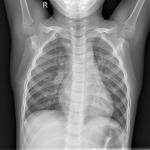

Image after transformation:


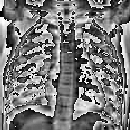

In [126]:
im,_ = ld_train.__getitem__(0)
imt, _ = ld_transform.__getitem__(0)

im = convert_image(im)
imt = convert_image(imt)

print("Image before transformation:")
display(im)
print("Image after transformation:")
display(imt)

Image Shape: (1, 130, 130)
Image Label: tensor([0., 0., 1.])


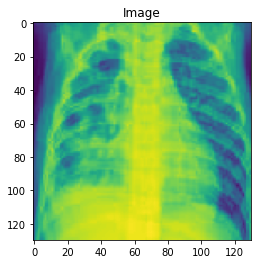

In [129]:
lda = Lung_Dataset_Analysis(transform)
img = lda.print_random_image()

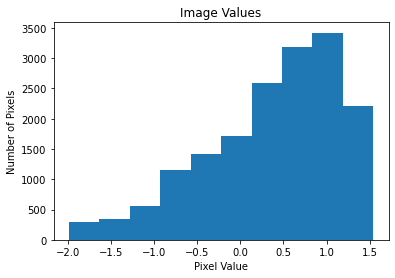

Min Value: -1.9916855096817017
Max Value: 1.5432027578353882


In [130]:
lda.print_image_plot(img)

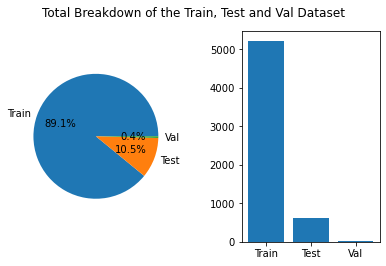

Train: 5216 images
Test: 615 images
Val: 25 images


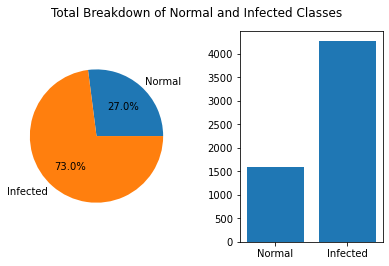

Normal: 1583 images
Infected: 4273 images


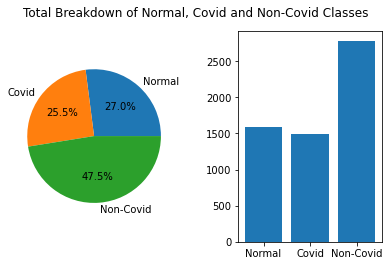

Normal: 1583 images
Covid: 1493 images
Non-Covid: 2780 images


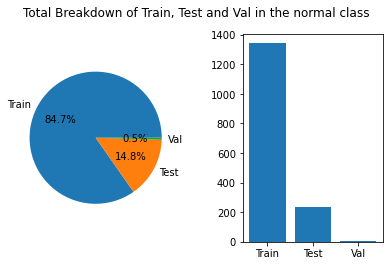

Train: 1341 images
Test: 234 images
Val: 8 images


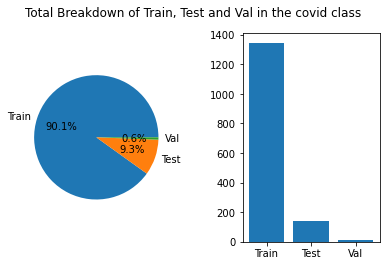

Train: 1345 images
Test: 139 images
Val: 9 images


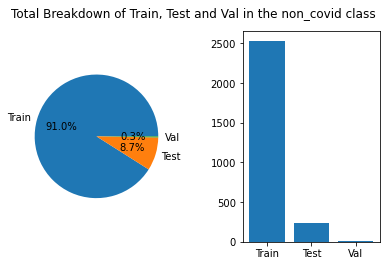

Train: 2530 images
Test: 242 images
Val: 8 images


In [131]:


lda.total_ttv_size()
lda.simple_class_size()
lda.total_class_size()
lda.class_size('normal')
lda.class_size('covid')
lda.class_size('non_covid')


# Everything below here is just for testing

In [200]:

ld_train.describe()
print(ld_train.dataset_numbers)

This is the Lung train Dataset in the 50.039 Deep Learning class project in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder ./dataset/train/infected/non-covid: 2530 images.

{'train_normal': 1341, 'train_infected_covid': 1345, 'train_infected_non_covid': 2530}


In [201]:
print(len(ld_train))
print(ld_train.__len__())

5216
5216


In [202]:
print(ld_train.dataset_numbers)

{'train_normal': 1341, 'train_infected_covid': 1345, 'train_infected_non_covid': 2530}


In [203]:
im, class_oh = ld_train[5217]
print(im.shape)
print(im)
print(class_oh)

AssertionError: Error - index_val variable should be an integer between 0 and the maximal number of images.
(In train/infected/non/covid, you have 2530 images.)

In [204]:
ld_test = Lung_Dataset('test', verbose = 1)
ld_val = Lung_Dataset('val', verbose = 1)

In [205]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 32

In [206]:
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

In [207]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.0431, 0.0000, 0.0000,  ..., 0.1020, 0.0863, 0.0667],
          [0.0000, 0.1490, 0.0000,  ..., 0.0157, 0.0039, 0.0000],
          [0.0471, 0.0000, 0.0235,  ..., 0.0118, 0.0039, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.1294, 0.1333, 0.2235,  ..., 0.2196, 0.1922, 0.1686],
          [0.2471, 0.2667, 0.2745,  ..., 0.2196, 0.1882, 0.1686],
          [0.2431, 0.1412, 0.1137,  ..., 0.2314, 0.1961, 0.1765],
          ...,
          [0.2196, 0.1686, 0.1569,  ..., 0.1333, 0.1686, 0.1529],
          [0.2157, 0.1804, 0.1490,  ..., 0.1765, 0.1686, 0.1451],
          [0.2157, 0.1922, 0.1451,  ..., 0.2078, 0.1725, 0.1608]]],


        [[[0.3686, 0.3961, 0.4275,  ..., 0.0431, 0.0549, 0.0588],
          [0.3843, 0.3922, 0.4078,  ..., 0.0392, 0.0431, 0.0431],
          [0.3686, 0.3608, 0.3

In [208]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 8 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(87616, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [209]:
model = Net()

In [210]:
# Try model on one mini-batch
for batch_idx, (images_data, target_labels) in enumerate(train_loader):
    predicted_labels = model(images_data)
    print(predicted_labels)
    print(target_labels)
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the mini-batch for loop"

tensor([[-0.4229, -1.0646],
        [-0.4213, -1.0678],
        [-0.4671, -0.9857],
        [-0.5370, -0.8783],
        [-0.5742, -0.8282],
        [-0.4885, -0.9508],
        [-0.4044, -1.1007],
        [-0.4798, -0.9647],
        [-0.4934, -0.9431],
        [-0.4418, -1.0297],
        [-0.4730, -0.9758],
        [-0.4976, -0.9364],
        [-0.5015, -0.9305],
        [-0.4963, -0.9385],
        [-0.4934, -0.9429],
        [-0.5404, -0.8735],
        [-0.4779, -0.9677],
        [-0.5136, -0.9121],
        [-0.5265, -0.8932],
        [-0.5439, -0.8686],
        [-0.5102, -0.9173],
        [-0.4019, -1.1057],
        [-0.4770, -0.9692],
        [-0.4972, -0.9371],
        [-0.4625, -0.9934],
        [-0.4657, -0.9880],
        [-0.4816, -0.9618],
        [-0.4699, -0.9811],
        [-0.4911, -0.9467],
        [-0.4894, -0.9493],
        [-0.4399, -1.0331],
        [-0.4972, -0.9371]], grad_fn=<LogSoftmaxBackward>)
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
       